In [29]:
%load_ext autoreload
%autoreload 2

from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax

import jaxley as jx
from jaxley.channels import Leak, HH
from jaxley.synapses import IonotropicSynapse
from jaxley.connection import connect

from jaxley_mech.synapses import RibbonSynapse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Ionotropic Synapse Reference

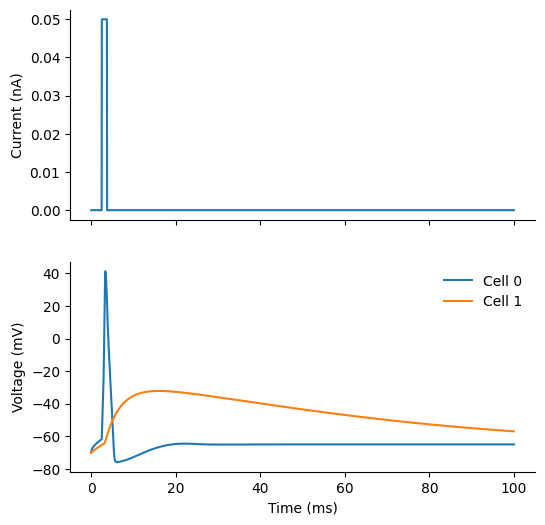

In [13]:
n_cells = 2
dt = 0.025
t_max = 100
_ = np.random.seed(0)

# Define a compartment, branch, and cell
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=1)
cell = jx.Cell(branch, parents=[-1])

# Define the network and connectivity
network = jx.Network([cell for _ in range(n_cells)])
connect(
    network.cell(0).branch(0).comp(0),
    network.cell(1).branch(0).comp(0),
    IonotropicSynapse(),
)
cell1 = network.cell([0])
cell2 = network.cell([1])

# Insert mechanisms
cell1.insert(HH())
cell2.insert(Leak())
network.IonotropicSynapse.set("IonotropicSynapse_gS", 1e-04)

network.delete_recordings()
network.cell(0).record(verbose=False)
network.cell(1).record(verbose=False)

time = jnp.arange(0, t_max, step=dt)
inp_current = jnp.zeros_like(time)
inp_current = inp_current.at[100:150].set(0.05)

data_stimuli = None
data_stimuli = network.cell(0).data_stimulate(inp_current, data_stimuli=data_stimuli)

v = jx.integrate(
    network, t_max=t_max, delta_t=dt, solver="bwd_euler", data_stimuli=data_stimuli
)

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

_ = ax[0].plot(time, inp_current)
_ = ax[1].plot(time, v[0, :-1], label="Cell 0")
_ = ax[1].plot(time, v[1, :-1], label="Cell 1")

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
plt.legend(frameon=False)
sns.despine();

### Deterministic Ribbon Synapse Model

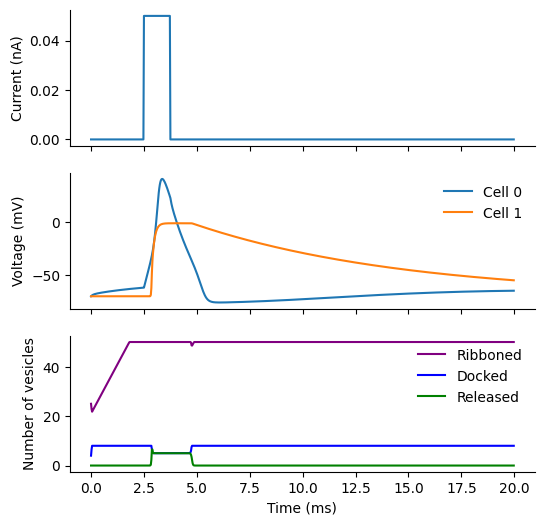

In [32]:
n_cells = 2
dt = 0.025
t_max = 20
_ = np.random.seed(0)

# Define a compartment, branch, and cell
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=1)
cell = jx.Cell(branch, parents=[-1])

# Define the network and connectivity
network = jx.Network([cell for _ in range(n_cells)])
connect(
    network.cell(0).branch(0).comp(0),
    network.cell(1).branch(0).comp(0),
    RibbonSynapse(),
)
cell1 = network.cell([0])
cell2 = network.cell([1])

network.RibbonSynapse.set("RibbonSynapse_gS", 1e-02)
network.RibbonSynapse.set("RibbonSynapse_tau", 0.5)

# Insert mechanisms
cell1.insert(HH())
cell2.insert(Leak())

network.delete_recordings()
network.cell(0).record(verbose=False)
network.cell(1).record(verbose=False)
network.cell(0).record("RibbonSynapse_ribboned", verbose=False)
network.cell(0).record("RibbonSynapse_docked", verbose=False)
network.cell(0).record("RibbonSynapse_released", verbose=False)

time = jnp.arange(0, t_max, step=dt)
inp_current = jnp.zeros_like(time)
inp_current = inp_current.at[100:150].set(0.05)

data_stimuli = None
data_stimuli = network.cell(0).data_stimulate(inp_current, data_stimuli=data_stimuli)

v = jx.integrate(
    network, t_max=t_max, delta_t=dt, solver="bwd_euler", data_stimuli=data_stimuli
)

fig, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

_ = ax[0].plot(time, inp_current)
_ = ax[1].plot(time, v[0, :-1], label="Cell 0")
_ = ax[1].plot(time, v[1, :-1], label="Cell 1")
ax[1].legend(frameon=False)
_ = ax[2].plot(time, v[2, :-1], label="Ribboned", color="purple")
_ = ax[2].plot(time, v[3, :-1], label="Docked", color="blue")
_ = ax[2].plot(time, v[4, :-1], label="Released", color="green")
ax[2].legend(frameon=False)

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[2].set_ylabel("Number of vesicles")
ax[2].set_xlabel("Time (ms)")
sns.despine();

#### Changing the probability of vesicle movement from the ribbon to the dock ($p_r$)

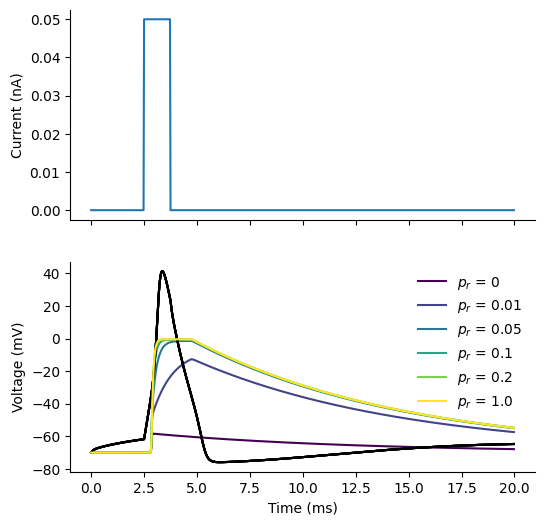

In [35]:
prs = [0, 0.01, 0.05, 0.1, 0.2, 1.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(prs)))

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
_ = ax[0].plot(time, inp_current)

for i, p in enumerate(prs):
    _ = np.random.seed(0)

    network.delete_recordings()
    network.cell(0).record(verbose=False)
    network.cell(1).record(verbose=False)

    network.RibbonSynapse.set("RibbonSynapse_p_r", p)

    v = jx.integrate(
        network, t_max=t_max, delta_t=dt, solver="bwd_euler", data_stimuli=data_stimuli
    )

    _ = ax[1].plot(time, v[0, :-1], color="k")
    _ = ax[1].plot(time, v[1, :-1], color=colors[i], label=f"$p_r$ = {p}")

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
plt.legend(frameon=False)
sns.despine();

If the probability is too low, not enough vesicles will be able to be docked to be releasable.

#### Changing the probability of vesicle movement from the cytoplasm to the ribbon (λ)

(In order for this parameter to have an effect, the initial number of vesicles at the ribbon should be reduced, or maybe the stimulus could be long enough to deplete the vesicles at the ribbon)

The trajectories shown indicate that the ribbon is depleted after the initial increase, as to be expected, after which a sufficient increase in movement from the cytoplasm to the ribbon can somewhat sustain the response.

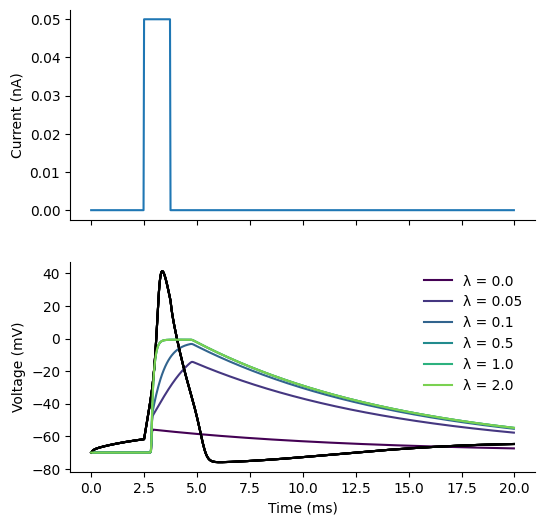

In [39]:
lams = np.array([0, 0.05, 0.1, 0.5, 1.0, 2.0])
colors = plt.cm.viridis(np.linspace(0, 0.8, len(lams)))

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
_ = ax[0].plot(time, inp_current)

for i, l in enumerate(lams):
    _ = np.random.seed(0)

    network.delete_recordings()
    network.cell(0).record(verbose=False)
    network.cell(1).record(verbose=False)

    network.RibbonSynapse.set("RibbonSynapse_ribboned", 1)
    network.set("RibbonSynapse_p_r", 0.1)
    network.RibbonSynapse.set("RibbonSynapse_lam", l)

    v = jx.integrate(
        network, t_max=t_max, delta_t=dt, solver="bwd_euler", data_stimuli=data_stimuli
    )

    _ = ax[1].plot(time, v[0, :-1], color="k")
    _ = ax[1].plot(time, v[1, :-1], color=colors[i], label=f"λ = {l}")

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
plt.legend(frameon=False)
sns.despine();

In [40]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-07-08 11:58:17CEST

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

jaxley_mech: 0.0.1

debugpy   : 1.6.3
ipykernel : 6.16.0
jaxley    : 0.0.0
numpy     : 1.26.4
seaborn   : 0.12.2
jax       : 0.4.26
matplotlib: 3.7.1

Watermark: 2.4.3

